# Joint cascade model with $A_\rm{eff}(E, \omega)$

Add in the 2D effective area to the model, instead of ignoring energy dependence as in the 1D case.

We could use spline evaluation, but I think here it will be quicker to have a 1D interpolation due to the need for an energy integral. In the end, will be good to check out both and compare. 

We can use the scipy spline to precompute the necessary integral and interpolate over $\alpha$ - see `precompute_exposure_integral.ipynb`.

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import stan_utility
import corner
from joint_model_cascades import * 

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
random_seed = 19920715

## Forward model

In [3]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1
selection = np.where(redshift < zth)[0]

In [4]:
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])

# Try ordering sources by redshift, as larger z => lower F
# This could help eliminate degeneracies in the mixture
inds = redshift.argsort()[::-1]
redshift = redshift[inds]
position = position[inds]
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

In [5]:
# Use simple Aeff calculated in `spline_dev/clean_spline_snippet.ipynb`
# Define spline 
p = 3 # spline degree
xknots = np.array([2.90998783, 4.03010253, 5.00991847, 6.96995941]) # knot sequence
yknots = np.array([-0.9,  0.1,  0.9]) # knot sequence
Nx = len(xknots)+p-1 # number of coefficients that need to be defined
Ny = len(yknots)+p-1 # number of coefficients that need to be defined
N = Nx * Ny

# Coefficients
c = np.asarray(
    [-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
     -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
     -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
     0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
     1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])
c = c.reshape(Nx, Ny)

In [6]:
# Get precomputed eps factor
with h5py.File('precomputed_eps_test.h5', 'r') as f:
    alpha_grid = f['alpha_grid'].value
    eps = f['eps'].value

In [7]:
with h5py.File('../data/Aeff_shape.h5', 'r') as f:
    log10Aeff = f['log10Aeff'].value

In [8]:
print('Max Aeff: ', np.max(10**log10Aeff))
Aeff_max = 31 # m^2 

Max Aeff:  30.300822794250863


## Simulation

In [9]:
# Prepare simulation inputs
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
dl = [luminosity_distance(z) for z in redshift[:-1]] # Mpc
sim_input['D'] = dl # Mpc
sim_input['varpi'] = unit_vector

# Energies
sim_input['alpha'] = 2.0
sim_input['Emin'] = 1.0e4 # GeV ie. 10 TeV
sim_input['f_E'] = 0.2 # 0.2

# Reconstruction 
sim_input['kappa'] = 100 # ~10 deg for cascades

# Associated fraction 
total_flux = 1e2 # m^-2 yr^-1
f = 0.5

Q = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) for d in dl])) ) # yr^-1
F0 = (1 - f) * total_flux # m^-2 yr^-1

sim_input['Q'] = Q # yr^-1
sim_input['F0'] = F0 # m^-2 yr^-1

# Exposure
sim_input['Ngrid'] = len(alpha_grid)
sim_input['alpha_grid'] = alpha_grid
sim_input['eps_grid'] = eps
sim_input['T'] = 1

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

print('Q: ', Q)
print('F0: ', F0)

Q:  2.9712629768847614e+53
F0:  50.0


In [10]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/joint_cascade_sim_2dAeff.stan', 
                                 model_name = 'Aeff_sim', include_paths = 'stan/')

Using cached StanModel


In [11]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

In [12]:
# Extract output
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad

source = Direction(unit_vector)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]

/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [13]:
# Labels
lam = simulation.extract(['lambda'])['lambda'][0] - 1
Nc = Ns
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)

Nsrc:  24
Nbg:  28


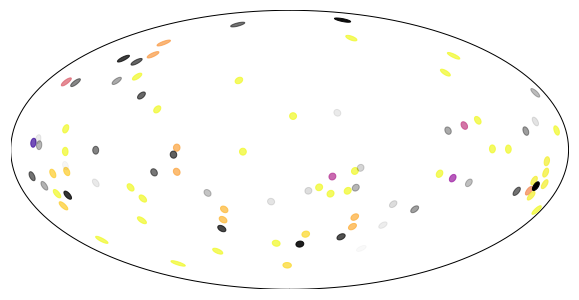

In [14]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = color, alpha = 0.7)
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = 'black', 
                  alpha = (1 - z/zth)/norm)

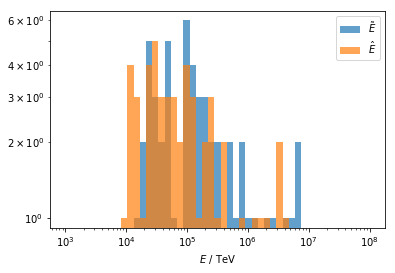

In [15]:
# Plot energies
Emin = sim_input['Emin']
bins = np.logspace(np.log(Emin/10), np.log(1E+4 * Emin), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins = bins, label = '$\\tilde{E}$', alpha = 0.7);
#ax.hist(E, bins = bins, label = '$E$', alpha = 0.7);
ax.hist(Edet, bins = bins, label = '$\hat{E}$', alpha = 0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.legend();

## Fit

In [16]:
# Compile the model
model = stan_utility.compile_model(filename = 'stan/joint_cascade_model_2dAeff.stan', 
                                   model_name = 'Aeff_model', 
                                   include_paths = 'stan/')

Using cached StanModel


In [17]:
# Prepare fit inputs
fit_input = {}
fit_input['N'] = len(event.unit_vector)
fit_input['omega_det'] = event.unit_vector
fit_input['Emin'] = sim_input['Emin']
fit_input['f_E'] = sim_input['f_E']
fit_input['Edet'] = Edet
fit_input['Ns'] = len(source.unit_vector)
fit_input['varpi'] = source.unit_vector
fit_input['D'] = sim_input['D']
fit_input['z'] = sim_input['z']
fit_input['kappa'] = sim_input['kappa']
fit_input['Ngrid'] = sim_input['Ngrid'] 
fit_input['alpha_grid'] = sim_input['alpha_grid'] 
fit_input['eps_grid'] = sim_input['eps_grid'] 
fit_input['T'] = sim_input['T']

# Spline
fit_input['p'] = sim_input['p']
fit_input['Lknots_x'] = sim_input['Lknots_x'] 
fit_input['Lknots_y'] = sim_input['Lknots_y'] 
fit_input['xknots'] = sim_input['xknots'] 
fit_input['yknots'] = sim_input['yknots'] 
fit_input['c'] = sim_input['c'] 

# Debugging
fit_input['alpha_true'] = sim_input['alpha']
fit_input['Q_scale'] = sim_input['Q']
fit_input['F0_scale'] = sim_input['F0']

In [18]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

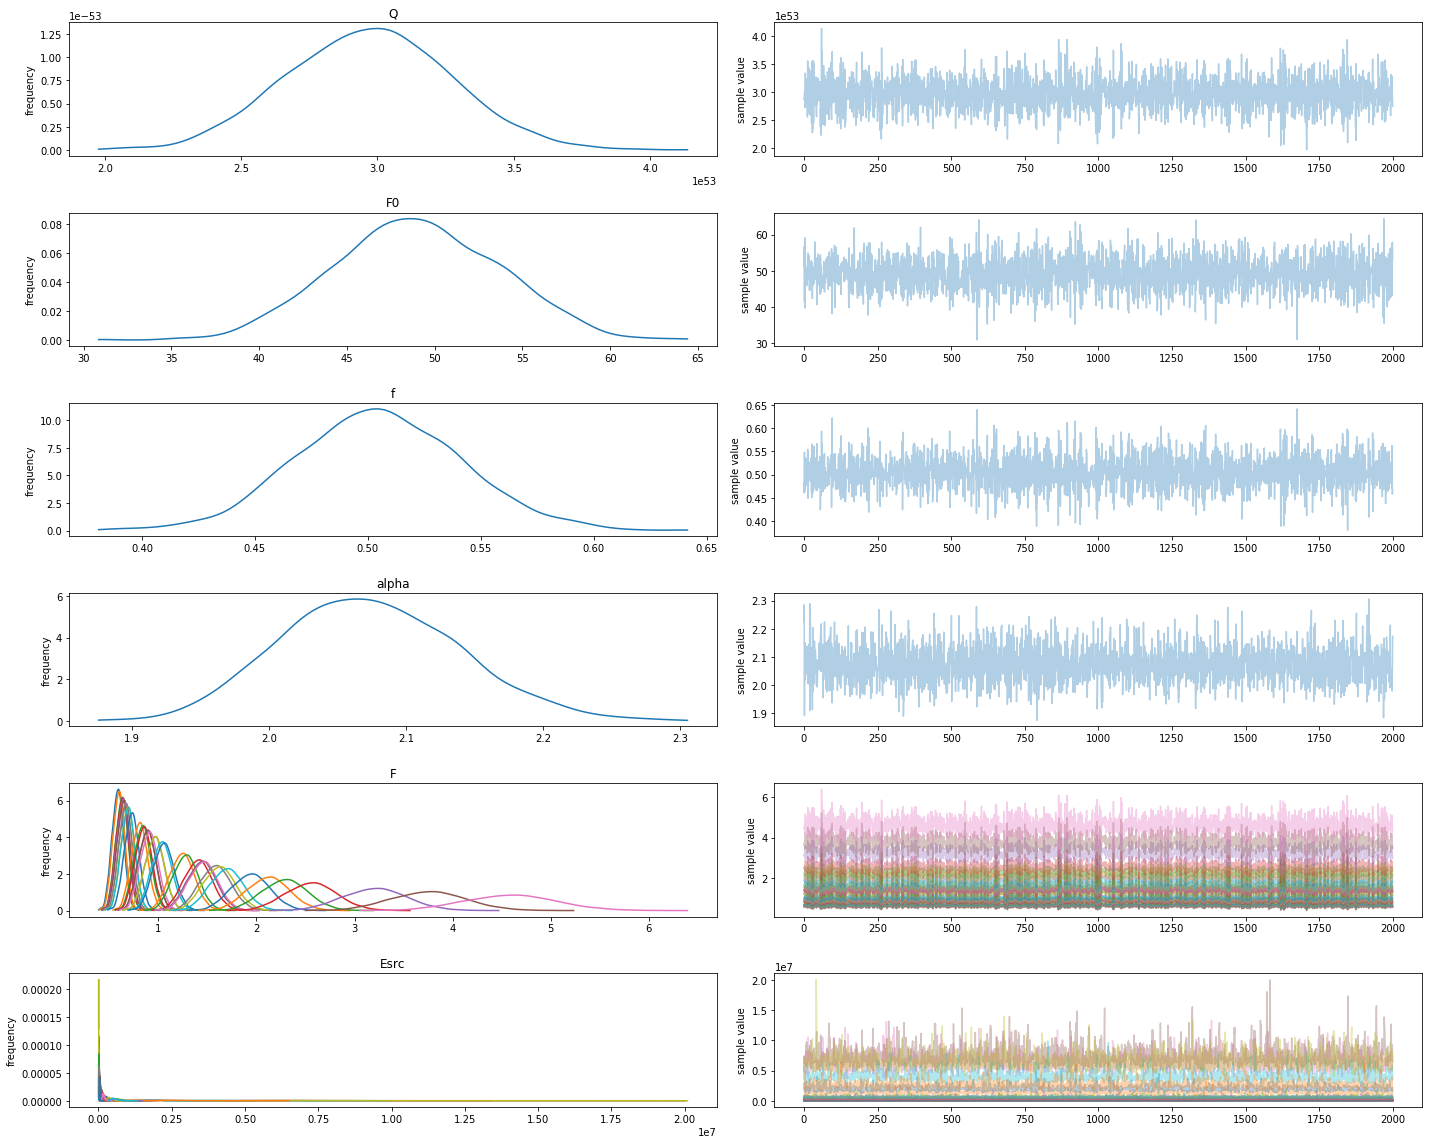

In [19]:
fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F', r'Esrc']);
fig.set_size_inches(20, 16)
fig.tight_layout()

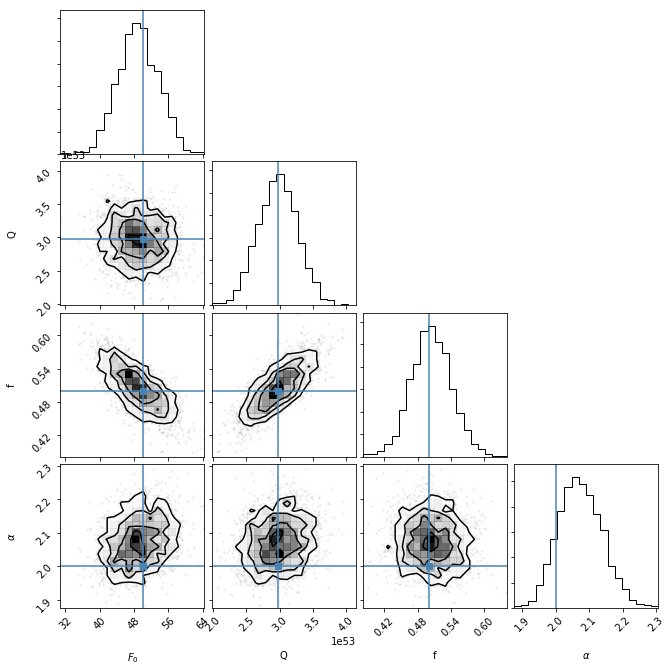

In [20]:
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'f', 'alpha']
labels = [r'$F_0$', r'Q', 'f', r'$\alpha$']
truths = [F0 , Q, f, sim_input['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

## Plotting priors

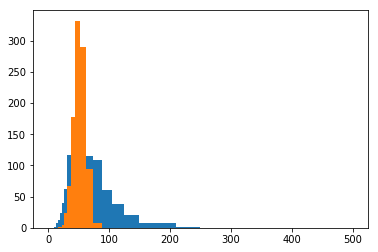

In [221]:
samples = np.random.lognormal(np.log(sim_input['F0']), 0.5, 1000)
samples_norm = np.random.normal(sim_input['F0'], 10, 1000)
bins = np.logspace(np.log(0.1), np.log(500), base = np.e)

fig, ax = plt.subplots()
ax.hist(samples, bins=bins);
ax.hist(samples_norm, bins=bins);
#ax.set_xscale('log')